In [1]:
from instrumentdatabaseapi import instrumentdatabaseapi as API

repo = API.Repository(local_repo=".")

In [2]:
print(repo)


URL: https://github.com/PaNOSC-ViNYL/instrument_database.git
local_dir: ./


Load the instrument configuration providing:
 - name of the institute
 - name of the instrument
 - version of the instrument description (HEAD is the most recent)
 - name of the simulation program

In [3]:
#help(repo)

In [4]:
repo.ls_institutes()

 - test_institute
 - ILL


In [5]:
repo.ls_instruments("ILL")
instrument_name="Panther"
#instrument_name="ThALES"

Available instruments for ILL:
 -  ILL/Panther
 -  ILL/D22
 -  ILL/ThALES


In [6]:
repo.ls_versions("ILL",instrument_name)

Available versions for instrument Panther:
 -  HEAD


In [7]:
repo.ls_simulation_programs("ILL",instrument_name,"HEAD")

Instrument Panther from institute ILL is implemented with the following programs:
 -  mcstas


In [8]:
repo.ls_flavours("ILL",instrument_name,"HEAD","mcstas")

Available flavours for instrument Panther:
 -  None
 -  nosection


In [9]:
flavour="nosection"
myinstrument = repo.load("ILL", instrument_name, "HEAD", "mcstas", flavour, dep=False)

L_bc5_fermi before BC3 =  1.6
7.7311000000000005


In [10]:
myinstrument.list_calculators()

- Instrument: Panther -
Calculators:
OriginCalc



In [11]:
print(myinstrument)

######## Instrument Panther
- Instrument: Panther -
Calculators:
OriginCalc
- ParametersCollection object -
  Master Parameters
  energy                                   [millielectron_volt]  Initial neutron energy   

   OriginCalc
    - Parameters object -
   mono_index                          -1                              Monochromator index, automatically based on the energy if set to -1   L[-1, 5]  
   a2                                  0          [degree]             Angle between beam reflected by monochromator and incident beam   L[36.0 degree, 58.97 degree](0 degree)
   mono_rv                             -1                              Monochromator vertical focusing: internally calculated if value is zero   
   mono_rh                             -1                              Monochromator horizontal focusing: internally calculated if value is zero   
   chopper_rpm                         0                               Fermi chopper speed   L[6000, 30000](0)
   chop

In [12]:
# setting the base directory for the simulation output
basedir = "/tmp/"+instrument_name+"/"
myinstrument.set_instrument_base_dir(basedir)

In [13]:
myinstrument.master

 - Parameters object -
energy                                   [millielectron_volt]  Initial neutron energy   

In [14]:
import pint
ureg = pint.get_application_registry()

if instrument_name == "ThALES":
    myinstrument.master["a2"] = myinstrument.energy_to_angle(4.98 * ureg.meV)
    myinstrument.master["a4"] = 60 * ureg.degree
    myinstrument.master["a6"] = myinstrument.master["a2"].pint_value
if instrument_name == "Panther":
    myinstrument.master["energy"]=19 * ureg.meV

In [15]:
myinstrument.samples

['None', 'vanadium', 'H2O', 'D2O', 'sqw']

In [16]:
myinstrument.set_sample_by_name("vanadium")

SPLIT 70 COMPONENT sqw = Isotropic_Sqw(
  Sqw_coh = 0, // [str]
  Sqw_inc = 0, // [str]
  radius = sample_radius, // [m]
  thickness = sample_thickness, // [m]
  xwidth = sample_width, // [m]
  yheight = sample_height, // [m]
  verbose = 2, // [1]
  d_phi = 43.60281897270362, // [deg]
  rho = 0.07232226802632531, // [AA-3]
  sigma_abs = 5.08, // [barns]
  sigma_coh = 0, // [barns]
  sigma_inc = 4.935, // [barns]
  p_interact = 1 // [1]
)
AT (0, 0, 0) RELATIVE sample_arm

In [17]:
myinstrument.sample_cylinder_shape(0.005, 0.01)

In [18]:
myinstrument.sim_neutrons(5e6)
myinstrument.set_seed(654321)

### Diagnostics of the beam for one calculator

In [19]:
mycalc = myinstrument.calculators["OriginCalc"]
mycalc.backengine()
#myinstrument.run()
print(mycalc.output)


INFO: Using directory: "/tmp/Panther/OriginCalc_3"
INFO: Regenerating c-file: OriginCalc.c
Info:    Defining SPLIT from sqw=Isotropic_Sqw() to END in instrument OriginCalc
CFLAGS=
        INFO: Recompiling: ./OriginCalc.out
mccode-r.c: In function ‘sighandler’:
mccode-r.c:3825:5: warning: implicit declaration of function ‘kill’; did you mean ‘ceill’? [-Wimplicit-function-declaration]
INFO: ===
lambda = 2.07
Selecting monochromator...mono_d = 3.3550
a2 = 36.03
mono_d = 3.3550
a2 = 36.03
mono_index = 1
dch = 0.08
Chopper_rpm = 9114.77
Neutron velocity: 1906.55
E_focus: 0.00
[OriginCalc] Initialize
Opening input file '/usr/local/mcstas/2.7.1/tools/Python/mcrun/../mccodelib/../../../data/Al2O3_sapphire.trm' (Table_Read_Offset)
DiskChopper: BC1: frequency=50.6376 [Hz] 3038.26 [rpm], time frame=0.00329136 [s] phase=0 [deg]
             6 slits, angle=41.3346 [deg] height=0.175 [m], width=0.15 [m] at radius=0.2125 [m]
Monochromator_curved: component Monochromator Q=1.87 Angs-1 (DM=3.355 Angs

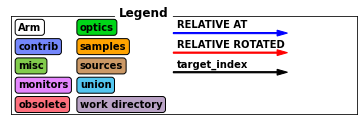

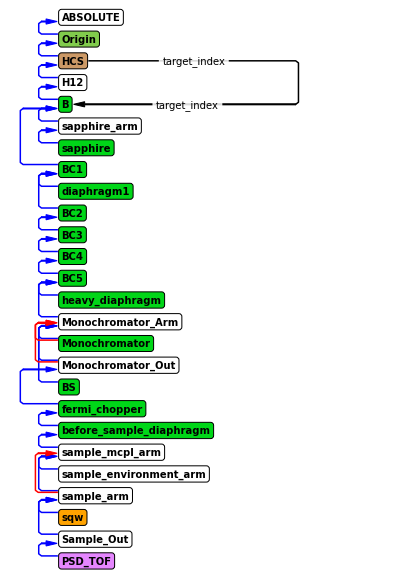

In [20]:
#mycalc = myinstrument.calculators["OriginCalc"]
#mycalc = myinstrument.calculators["SampleCalc"]
#mycalc.input = myinstrument.calculators["OriginCalc"].output
mycalc.show_diagram()

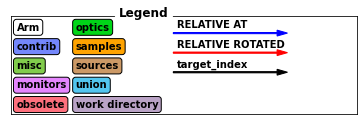

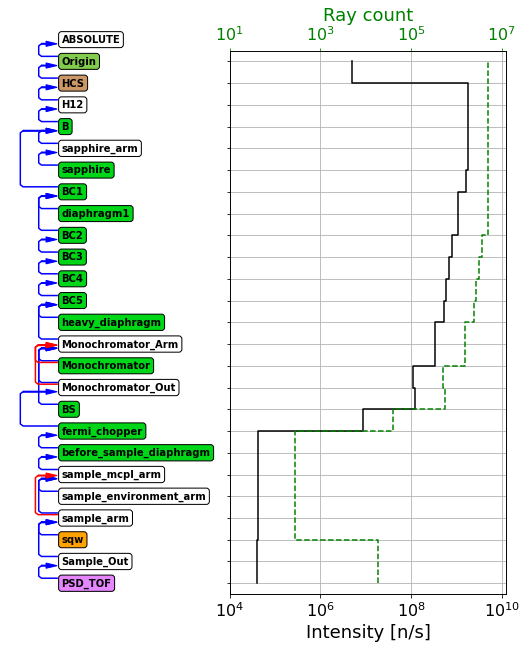

In [21]:
mycalc.show_diagram(analysis=True)

In [22]:
import mcstasscript as ms


In [28]:
diag = ms.Diagnostics(mycalc)
diag.settings(ncount=1e7, suppress_output=True)
diag.show_settings()
diag.clear_points()

elements = []
if len(elements) == 0:
    for component in diag.instr.component_list:
        if(component.component_name in ["Progress_bar", "Arm","Beamstop"]):
            continue
        elements.append(component.name)

print(elements)

for element in elements:
    diag.add_point(after=element)
    #diag.add_point(before=element)

if mycalc.name == "SampleCalc":
    diag.clear_points()
    diag.add_point(after="Vin")
    diag.add_point(before="sqw")
    diag.add_point(after="Sample_Out")
    diag.add_point(before="after_sample_slit")
    diag.add_point(after="after_sample_slit")

print(diag)


Instrument settings:
  ncount:           1.00e+07
  seed:             654321
  output_path:      /tmp/Panther/OriginCalc
  run_path:         ./
  package_path:     /usr/local/mcstas/2.7.1/
  executable_path:  /usr/local/mcstas/2.7.1//bin/
  executable:       mcrun
  force_compile:    True
['HCS', 'B', 'sapphire', 'BC1', 'diaphragm1', 'BC2', 'BC3', 'BC4', 'BC5', 'heavy_diaphragm', 'Monochromator', 'fermi_chopper', 'before_sample_diaphragm', 'sqw', 'PSD_TOF']
Instrument diagnostics for: OriginCalc
Diagnostics points: 
  Diagnostics point after:  HCS                       - rays: 50000
  Diagnostics point after:  B                         - rays: 50000
  Diagnostics point after:  sapphire                  - rays: 50000
  Diagnostics point after:  BC1                       - rays: 50000
  Diagnostics point after:  diaphragm1                - rays: 50000
  Diagnostics point after:  BC2                       - rays: 50000
  Diagnostics point after:  BC3                       - rays: 50000
  

In [29]:
diag.run()

In [33]:
diag.clear_views()
#diag.add_view("t")
diag.add_view("x", bins=50, limits=[-0.04,0.04])
diag.add_view("y", bins=50, same_scale=False, limits=[-0.07,0.07])
diag.add_view("x","y",bins=[30,30])
diag.add_view("e", same_scale=True)
diag.add_view("t",same_scale=False)

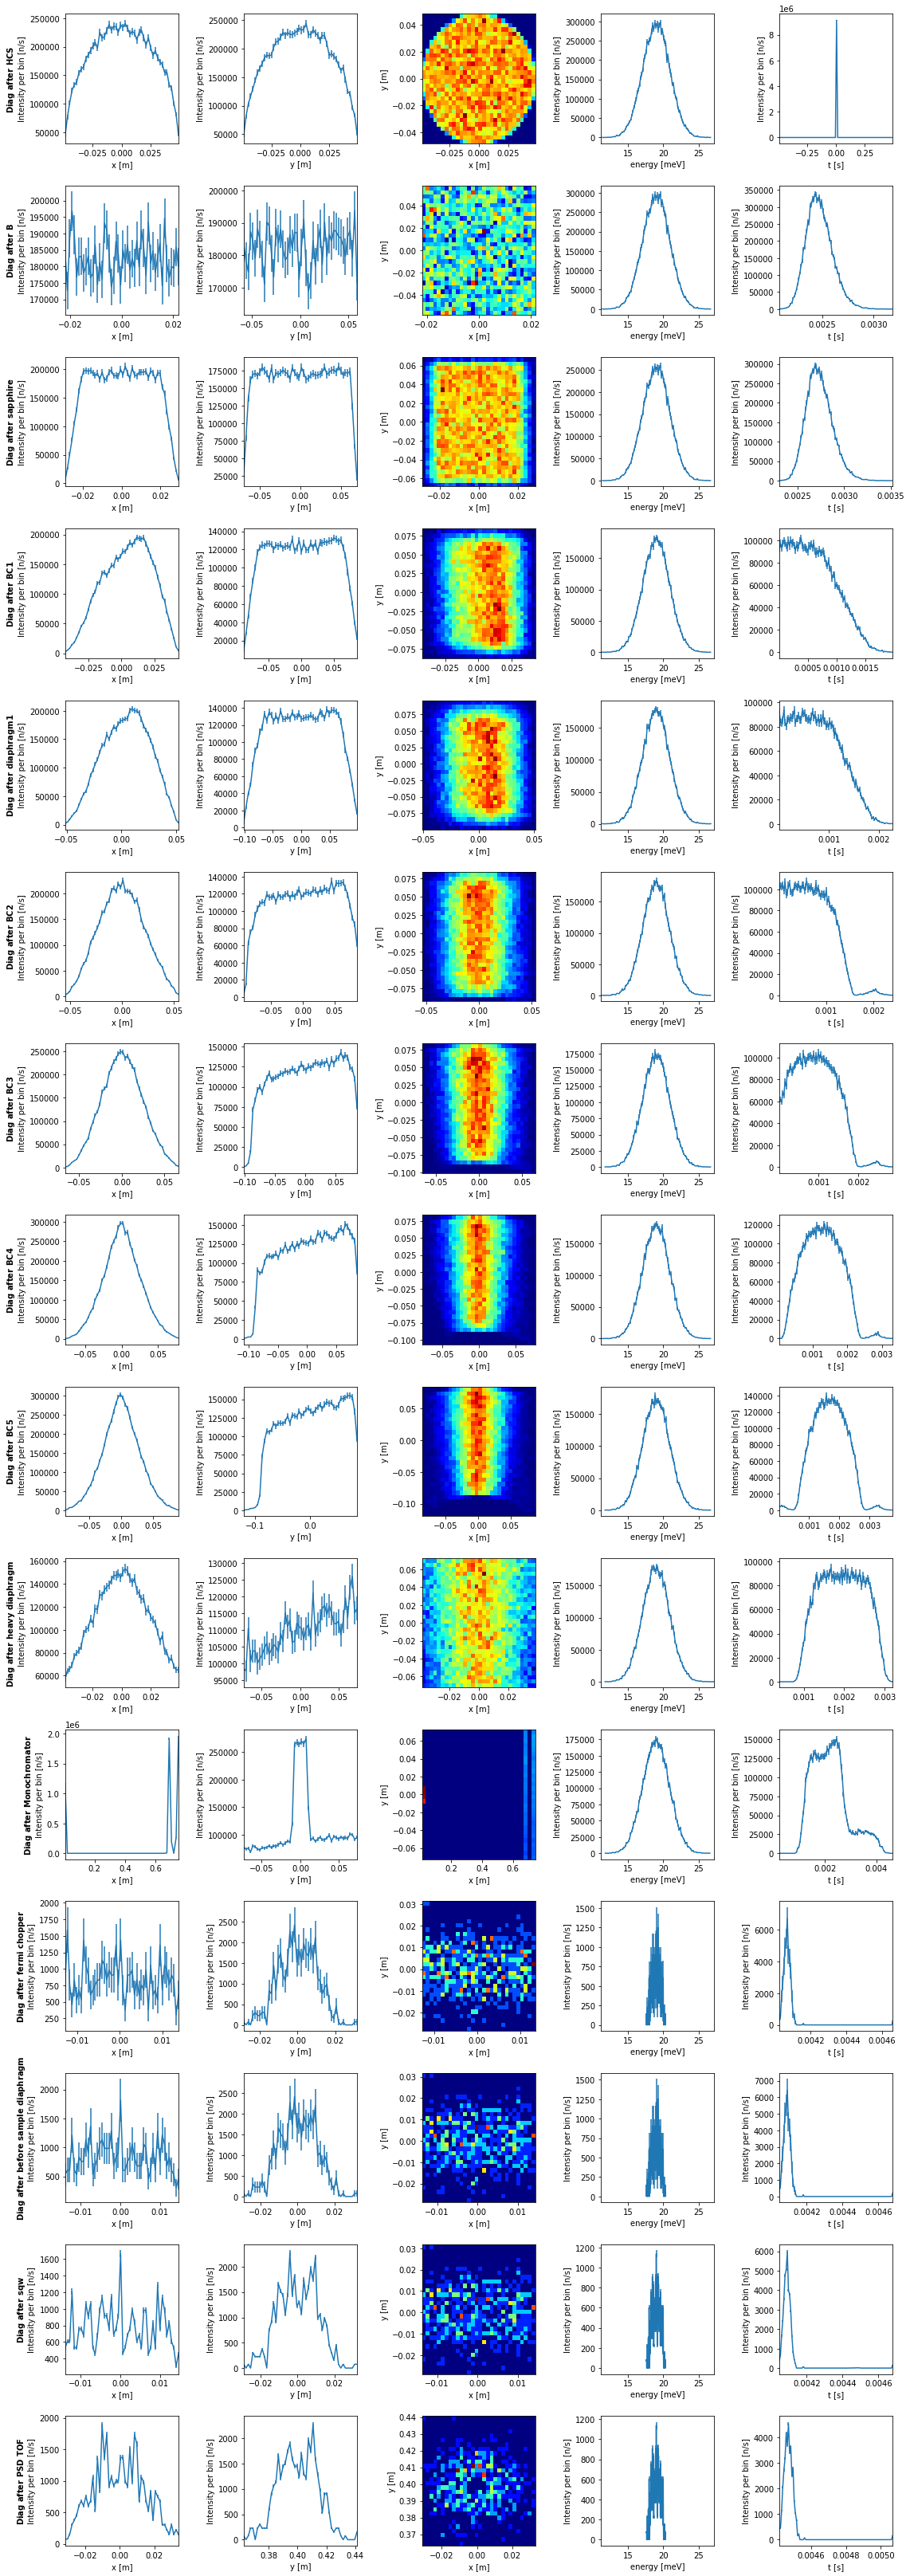

In [34]:
diag.plot()

In [32]:
mycalc.show_instrument()


loading system configuration
        lambda = 2.07
Selecting monochromator...mono_d = 3.3550
a2 = 36.03
mono_d = 3.3550
a2 = 36.03
mono_index = 1
dch = 0.08
Chopper_rpm = 9114.77
Neutron velocity: 1906.55
E_focus: 0.00

INFO: Using directory: "OriginCalc_mcdisplay_0"
INFO: Regenerating c-file: OriginCalc.c
Info:    Defining SPLIT from sqw=Isotropic_Sqw() to END in instrument OriginCalc
CFLAGS=
INFO: Recompiling: ./OriginCalc.out
mccode-r.c: In function ‘sighandler’:
mccode-r.c:3825:5: warning: implicit declaration of function ‘kill’; did you mean ‘ceill’? [-Wimplicit-function-declaration]
INFO: ===
is probably too low. Increase Ncount.
instrument definition parsed
reading particle data...
        lambda = 2.07
Selecting monochromator...mono_d = 3.3550
a2 = 36.03
mono_d = 3.3550
a2 = 36.03
mono_index = 1
dch = 0.08
Chopper_rpm = 9114.77
Neutron velocity: 1906.55
E_focus: 0.00

Component                         Origin AT (0,0,0)    0 m from origin
Component                            HC

In [ ]:
ms.make_sub_plot(data_empty[55:59])

In [ ]:
ms.make_sub_plot(data_empty[65:69])

In [ ]:
%matplotlib widget
import mcstasscript.jb_interface as ms_widget
ms_widget.show(data_empty)